# <center> **Machine Learning for Social Data Science** </center>

## <center> **Problem Set 1** </center>

## <center> *Machine Learning the Identities of Labour’s Electorate: Random Forest (Bagged Decision Trees) and XGBoost (Boosted Decision Trees) on BES Wave 30 (1,500 words)* </center>

### **Preprocessing**

In [1]:
#Import dataset
import pandas as pd

df = pd.read_stata("../../../Statistical Modelling/Assessments/BES2024_W30_v30.0.dta")

In [2]:
#Subset to keep key variables
BES = df[["id", "generalElectionVote", "age", "gender", "p_ethnicity", "p_religion", 
          "p_sexuality", "p_disability", "p_edlevel", "subjClass", "gor"]].copy()

#Rename column names
BES = BES.rename(columns = {"generalElectionVote": "General_Election_Vote", "age": "Age", "gender": "Gender", "p_ethnicity": "Ethnicity",
"p_religion": "Religion", "p_sexuality": "Sexuality", "p_disability": "Disability", "p_edlevel": "Education_Level", "subjClass": "Subjective_Class",
"gor": "Region"})

In [3]:
#Preprocess Target Variable
BES["Labour_vote"] = (BES["General_Election_Vote"] == 'Labour').astype(int)

#Preprocess features
from sklearn.preprocessing import LabelEncoder
from sklearn import preprocessing
import numpy as np

#Ensure all strings are set as categories
categorical_variables = ['Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region']

for col in categorical_variables:
    BES[col] = BES[col].astype('category')

In [4]:
#Summary statistics
BES.describe(include = 'all')

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
count,30342.000000,29800,30342.0,30342,30342,30104,30227,29837,26273,30342,30342,30342.000000
unique,NaN,10,79.0,2,16,19,5,3,6,5,12,NaN
top,NaN,Brexit Party/Reform UK,69.0,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,"Yes, working class",South East,NaN
freq,NaN,7226,749.0,16751,26579,16071,26250,20029,9200,12131,4410,NaN
mean,67896.568453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.177675
std,39248.025493,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.382245
min,18.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,33155.250000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
50%,70868.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
75%,104337.750000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000


In [5]:
#Eyeball data to ensure it is ready for analysis
BES.sample(25)

,id,General_Election_Vote,Age,Gender,Ethnicity,Religion,Sexuality,Disability,Education_Level,Subjective_Class,Region,Labour_vote
7664,34174,Labour,41,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Undergraduate,Don't know,London,1
18217,83994,Brexit Party/Reform UK,74,Female,White British,Yes - Church of England/Anglican/Episcopal,Heterosexual,"Yes, limited a lot",NaN,No,Yorkshire and the Humber,0
8459,39310,Don't know,43,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,Postgrad,"Yes, middle class",South West,0
19274,87269,Conservative,78,Female,White British,Yes - Church of England/Anglican/Episcopal,Heterosexual,No,GCSE,"Yes, middle class",South East,0
9253,43617,Labour,54,Male,White British,Yes - Church of England/Anglican/Episcopal,Gay or lesbian,"Yes, limited a little",GCSE,"Yes, working class",Yorkshire and the Humber,1
14309,66032,I would/did not vote,56,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,GCSE,"Yes, working class",South West,0
7924,35709,I would/did not vote,40,Male,White British,"No, I do not regard myself as belonging to any...",Heterosexual,No,A-level,"Yes, working class",North West,0
1537,5865,Conservative,75,Female,White British,Prefer not to say,Heterosexual,No,Undergraduate,"Yes, middle class",South West,0
20118,90746,Conservative,62,Male,White British,Yes - Church of England/Anglican/Episcopal,Prefer not to say,No,NaN,No,East Midlands,0
6717,26798,Brexit Party/Reform UK,82,Female,White British,"No, I do not regard myself as belonging to any...",Heterosexual,"Yes, limited a little",No qualifications,"Yes, working class",East Midlands,0


### **Findings**

#### **XGBoost**

In [6]:
#Choose feature and target variables
features = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 'Education_Level', 'Subjective_Class', 'Region'] 
target = 'Labour_vote'

In [7]:
#Model 1 - Baseline

#Seperate into train and test sets 80/20
from sklearn.model_selection import train_test_split

BES_train, BES_test = train_test_split(BES, test_size = 0.2, random_state = 42)

#Create binary/logistic XGBoost model
import xgboost as xgb 

model1 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           eval_metric = 'logloss')

#Train model
model1.fit(BES_train[features], BES_train[target])

#Predict on test set
pred1 = model1.predict(BES_test[features])


probability_model1 = model1.predict_proba(BES_test[features])[:,1]

#Calculate Metrics
from sklearn.metrics import precision_score, f1_score, recall_score, average_precision_score

metrics1 = {
    'Precision': precision_score(BES_test[target], pred1),
    'Recall': recall_score(BES_test[target], pred1),
    'F1': f1_score(BES_test[target], pred1),
    'PR-AUC': average_precision_score(BES_test[target], probability_model1)}

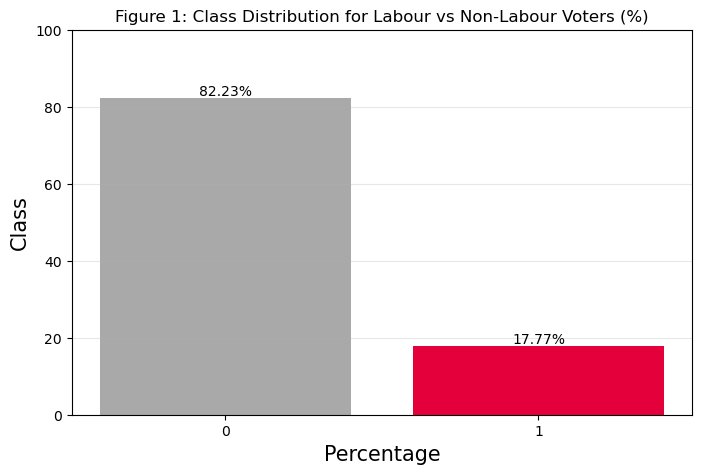

In [8]:
#Create figure to display class imbalance as a barplot with percentages
import matplotlib.pyplot as plt

#Calculate class percentages
class_percentage = BES['Labour_vote'].value_counts(normalize = True).sort_index() * 100

#Make plot
plt.figure(figsize = (8, 5))
plt.bar(class_percentage.index.astype(str), class_percentage.values, color = ['darkgrey', '#E4003B'])

plt.title('Figure 1: Class Distribution for Labour vs Non-Labour Voters (%)')
plt.ylabel('Class', fontsize = 15)
plt.xlabel('Percentage', fontsize = 15)
plt.ylim(0, 100)
plt.grid(axis = 'y', alpha = 0.3)

#Add and format percentages
for i, pct in enumerate(class_percentage.values):
    plt.text(i, pct, f'{pct:.2f}%', ha = 'center', va = 'bottom')

plt.savefig('Figure_1.png')

In [9]:
#Model 2 - Stratified

#Test/train split with stratification 
BES_train_stratified, BES_test_stratified = train_test_split(BES, test_size = 0.2, random_state = 42, stratify = BES[target])

#Checking classes are balanced
print(sum(BES_train_stratified[target])/len(BES_train_stratified[target]))
print(sum(BES_test_stratified[target])/len(BES_test_stratified[target]))

model2 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           eval_metric = 'logloss')

model2.fit(BES_train_stratified[features], BES_train_stratified[target])

pred2 = model2.predict(BES_test_stratified[features])

probability_model2 = model2.predict_proba(BES_test[features])[:,1]

metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], pred2),
    'Recall': recall_score(BES_test_stratified[target], pred2),
    'F1': f1_score(BES_test_stratified[target], pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model2)}

0.17768714209203643
0.1776239907727797


In [10]:
#Model 3 - Scale Weight

#Create scale weight
negative = sum(BES_train_stratified[target] == 1) 
positive = sum(BES_train_stratified[target] == 0)

print(positive/negative)

model3 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss')

model3.fit(BES_train_stratified[features], BES_train_stratified[target])

pred3 = model3.predict(BES_test_stratified[features])

probability_model3 = model3.predict_proba(BES_test[features])[:,1]

metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], pred3),
    'Recall': recall_score(BES_test_stratified[target], pred3),
    'F1': f1_score(BES_test_stratified[target], pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model3)}

4.627869232552747


In [11]:
#Model 4 - Threshold

model4 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss')

model4.fit(BES_train_stratified[features], BES_train_stratified[target])

probability_model4 = model4.predict_proba(BES_test_stratified[features])[:,1]

threshold = 0.15
pred4 = (probability_model4 >= threshold).astype(int)

metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], pred4),
    'Recall': recall_score(BES_test_stratified[target], pred4),
    'F1': f1_score(BES_test_stratified[target], pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model4)}

In [12]:
#Bayesian Optimisation - altered from Antigravity AI Response(Chat History - Appendix B)
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, average_precision_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# --- PREPARATION ---

# First, separate your features (X) and target variable (y) from your datasets
X_train = BES_train_stratified.drop('Labour_vote', axis=1) 
y_train = BES_train_stratified['Labour_vote']

X_test = BES_test_stratified.drop('Labour_vote', axis=1)
y_test = BES_test_stratified['Labour_vote']


# --- STEP 1: Set up the hyperopt search space ---

# Define the boundaries for the XGBClassifier hyperparameters you want to optimize
# - hp.quniform returns values rounded to the nearest given step (useful for integers)
# - hp.uniform returns continuous floats within the range
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),              # Depth of the tree (integers roughly 3 to 10)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),      # Step size shrinkage (continuous 0.01 to 0.3)
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),     # Number of boosting rounds (trees)
    'subsample': hp.uniform('subsample', 0.5, 1.0),               # Fraction of observations to safely sample per tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # Fraction of columns to sample per tree
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),# Minimum instance weight needed in a child
    'gamma': hp.uniform('gamma', 0.0, 5.0)                        # Minimum loss reduction required for split
}


# --- STEP 2: Define objective function minimizing negative F1 score ---

def objective(params):
    # hyperopt passes parameters as floats by default if using uniform/quniform.
    # We must cast the hyperparameters that XGBoost expects to be integers.
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Initialize the XGBClassifier with the current set of parameters proposed by hyperopt
    clf = XGBClassifier(
        **params,
        enable_categorical=True,                                                                                                  #Added by me
        scale_pos_weight = positive/negative,                                                                                     #Added by me
        random_state=42,       # Ensures reproducibility
        eval_metric='logloss'  # Prevents unnecessary iteration warnings in newer XGBoost versions
    )
    
    # Train the model on the stratified training data
    clf.fit(X_train, y_train)
    
    # Predict on the stratified test data
    preds = clf.predict(X_test)
    
    # Calculate the positive F1 score (harmonic mean of precision and recall)

    prauc = average_precision_score(y_test, preds)                                                                              #Altered from F1 to PR-AUC 
    
    # hyperopt is designed to strictly MINIMIZE the return value of the objective function.
    # Therefore, to maximize the F1 score, we return the negative F1 score.                                                     #Altered from F1 to PR-AUC 
    # STATUS_OK tells hyperopt that the function executed successfully without errors.
    return {'loss': -prauc, 'status': STATUS_OK}

# --- STEP 3: Run Bayesian optimization with 50 evaluations ---

# The Trials object will keep a record of all the hyperparameters and corresponding losses evaluated
trials = Trials()

# fmin is the main optimization function built into hyperopt
best = fmin(
    fn=objective,                    # The objective function we just defined above
    space=space,                     # The hyperparameter search space
    algo=tpe.suggest,                # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=50,                    # The number of models/evaluations to test (50, as requested)
    trials=trials,                   # The history dictionary to record metrics
    rstate=np.random.default_rng(42) # Random state for consistent/reproducible optimization behavior
)

                                                                                                                                    #Convert necessary parameters to integer by me 
for key in best:
    if key in ['max_depth', 'min_child_weight', 'n_estimators']:
        best[key] = int(best[key])

# Output the best hyperparameters discovered
print("Best hyperparameters found during the Bayseian Search:", best)                                                              #Simplified to one print statement by me

100%|██████████| 50/50 [00:34<00:00,  1.47trial/s, best loss: -1.0]
Best hyperparameters found during the Bayseian Search: {'colsample_bytree': np.float64(0.8577792295565498), 'gamma': np.float64(0.5689813359180357), 'learning_rate': np.float64(0.23267835535195902), 'max_depth': 8, 'min_child_weight': 9, 'n_estimators': 330, 'subsample': np.float64(0.9068277038201439)}


In [13]:
#Model 5 - Best Hyperparameters

model5 = xgb.XGBClassifier(objective = 'binary:logistic', 
                           enable_categorical = True,
                           scale_pos_weight = positive/negative,
                           eval_metric = 'logloss',
                           **best)

model5.fit(BES_train_stratified[features], BES_train_stratified[target])

probability_model5 = model5.predict_proba(BES_test_stratified[features])[:,1]

threshold = 0.15
pred5 = (probability_model5 >= threshold).astype(int)

metrics5 = {
    'Precision': precision_score(BES_test_stratified[target], pred5),
    'Recall': recall_score(BES_test_stratified[target], pred5),
    'F1': f1_score(BES_test_stratified[target], pred5),
    'PR-AUC': average_precision_score(BES_test_stratified[target], probability_model5)}

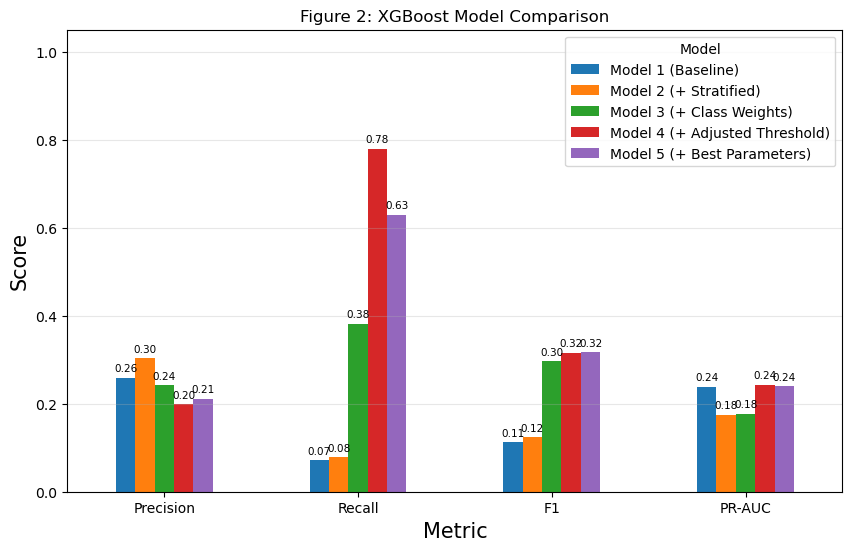

In [14]:
#Plot metrics

xgboost_model_scores = pd.DataFrame({
    'Model 1 (Baseline)': metrics1,
    'Model 2 (+ Stratified)': metrics2,
    'Model 3 (+ Class Weights)': metrics3,
    'Model 4 (+ Adjusted Threshold)': metrics4,
    "Model 5 (+ Best Parameters)": metrics5})

ax = xgboost_model_scores.plot(kind = 'bar', figsize = (10, 6))

#Add percentages
for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7.5)

plt.title('Figure 2: XGBoost Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1.05)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)

plt.savefig('Figure_2.png')

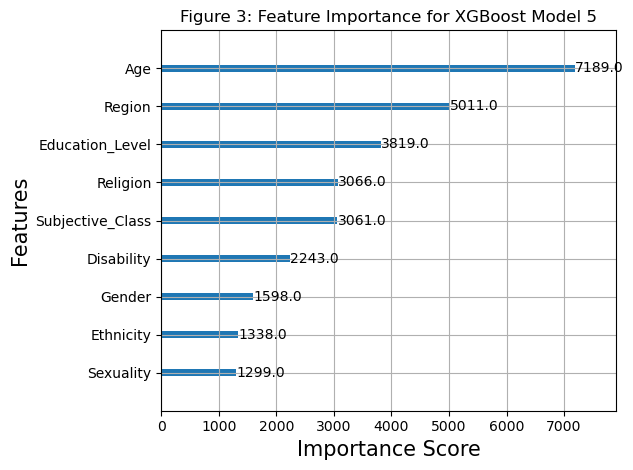

In [15]:
#Plot feature importance for model 5
import matplotlib.pyplot as plt

xgb.plot_importance(model5, importance_type = 'weight')
plt.title('Figure 3: Feature Importance for XGBoost Model 5')
plt.ylabel('Features', fontsize = 15)
plt.xlabel('Importance Score', fontsize = 15)

plt.tight_layout()
plt.savefig('Figure_3.png')

#### **Random Forest**

In [16]:
#One-hot encode train and test sets
BES_train = BES_train.drop('General_Election_Vote', axis = 1)
BES_test = BES_test.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train = pd.get_dummies(BES_train, columns = categorical_variables) 
BES_test = pd.get_dummies(BES_test, columns = categorical_variables)

BES_test = BES_test.reindex(columns = BES_train.columns)
features = BES_train.columns.drop([target, 'id'])

In [17]:
#Model 1 - Baseline
from sklearn.ensemble import RandomForestClassifier

rf1 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf1.fit(BES_train[features], BES_train[target])

rf_pred1 = rf1.predict(BES_test[features])

rf1_probability = rf1.predict_proba(BES_test[features])[:,1]

rf_metrics1 = {
    'Precision': precision_score(BES_test[target], rf_pred1),
    'Recall': recall_score(BES_test[target], rf_pred1),
    'F1': f1_score(BES_test[target], rf_pred1),
    'PR-AUC': average_precision_score(BES_test[target], rf1_probability)}

In [18]:
#Model 2 - Stratified
BES_train_stratified = BES_train_stratified.drop('General_Election_Vote', axis = 1)
BES_test_stratified = BES_test_stratified.drop('General_Election_Vote', axis = 1)

categorical_variables = ['Age', 'Gender', 'Ethnicity', 'Religion', 'Sexuality', 'Disability', 
                         'Education_Level', 'Subjective_Class', 'Region']

BES_train_stratified = pd.get_dummies(BES_train_stratified, columns = categorical_variables) 
BES_test_stratified = pd.get_dummies(BES_test_stratified, columns = categorical_variables)

BES_test_stratified = BES_test_stratified.reindex(columns = BES_train_stratified.columns)
features = BES_train_stratified.columns.drop([target, 'id'])

rf2 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 42)

rf2.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred2 = rf2.predict(BES_test_stratified[features])

rf2_probability = rf2.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics2 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred2),
    'Recall': recall_score(BES_test_stratified[target], rf_pred2),
    'F1': f1_score(BES_test_stratified[target], rf_pred2),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf2_probability)}

In [19]:
#Model 3 - Weights
rf3 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf3.fit(BES_train_stratified[features], BES_train_stratified[target])

rf_pred3 = rf3.predict(BES_test_stratified[features])

rf3_probability = rf3.predict_proba(BES_test_stratified[features])[:,1]

rf_metrics3 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred3),
    'Recall': recall_score(BES_test_stratified[target], rf_pred3),
    'F1': f1_score(BES_test_stratified[target], rf_pred3),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf3_probability)}

In [20]:
#Model 4 - Adjusted Probaility Threshold
rf4 = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', class_weight = 'balanced', random_state = 42)

rf4.fit(BES_train_stratified[features], BES_train_stratified[target])

rf4_probability = rf4.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred4 = (rf4_probability > threshold).astype(int)

rf_metrics4 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred4),
    'Recall': recall_score(BES_test_stratified[target], rf_pred4),
    'F1': f1_score(BES_test_stratified[target], rf_pred4),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf4_probability)}

In [21]:
#Hyperparameter Optimisation - limited due to run time
from sklearn.model_selection import RandomizedSearchCV

parameter_distributions = {
    'n_estimators': [100, 200],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'criterion': ['gini', 'entropy']}

rf = RandomForestClassifier(class_weight= 'balanced', random_state = 42)

random_search = RandomizedSearchCV(
    estimator = rf,
    param_distributions = parameter_distributions,
    n_iter = 5,
    scoring = 'average_precision',
    cv = 5,
    return_train_score = True,
    n_jobs = -1,
    verbose = 2,
    random_state = 42)

random_search.fit(BES_train_stratified[features], BES_train_stratified[target])

best_rf = random_search.best_estimator_

rf_probability = best_rf.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_prob = (rf_probability > threshold).astype(int)

print("Best hyperparameters:", random_search.best_params_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Best hyperparameters: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'log2', 'max_depth': 15, 'criterion': 'entropy'}


In [22]:
#Model 5 - Best Hyperparamters
rf5 = RandomForestClassifier(n_estimators = 200, 
                             max_features = 'log2',
                             max_depth = 15,
                             min_samples_split = 5,
                             min_samples_leaf = 4,
                             criterion = 'entropy', 
                             class_weight = 'balanced', 
                             random_state = 42)

rf5.fit(BES_train_stratified[features], BES_train_stratified[target])

rf5_probability = rf5.predict_proba(BES_test_stratified[features])[:, 1]

threshold = 0.15
rf_pred5 = (rf5_probability > threshold).astype(int)

rf_metrics5 = {
    'Precision': precision_score(BES_test_stratified[target], rf_pred5),
    'Recall': recall_score(BES_test_stratified[target], rf_pred5),
    'F1': f1_score(BES_test_stratified[target], rf_pred5),
    'PR-AUC': average_precision_score(BES_test_stratified[target], rf5_probability)}

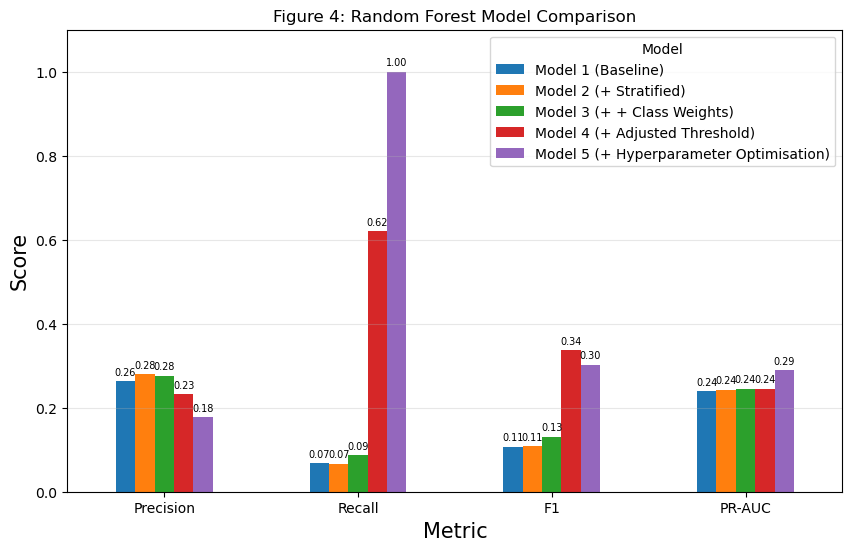

In [23]:
#Plot metrics
random_forest_scores = pd.DataFrame({
    'Model 1 (Baseline)': rf_metrics1,
    'Model 2 (+ Stratified)': rf_metrics2,
    'Model 3 (+ + Class Weights)': rf_metrics3,
    'Model 4 (+ Adjusted Threshold)': rf_metrics4,
    'Model 5 (+ Hyperparameter Optimisation)': rf_metrics5})

ax = random_forest_scores.plot(kind = 'bar', figsize = (10, 6))

for container in ax.containers:
    ax.bar_label(container, fmt = '%.2f', padding = 3, fontsize = 7)

plt.title('Figure 4: Random Forest Model Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.ylim(0, 1.1)
plt.xticks(rotation = 0)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)

plt.savefig('Figure_4.png')

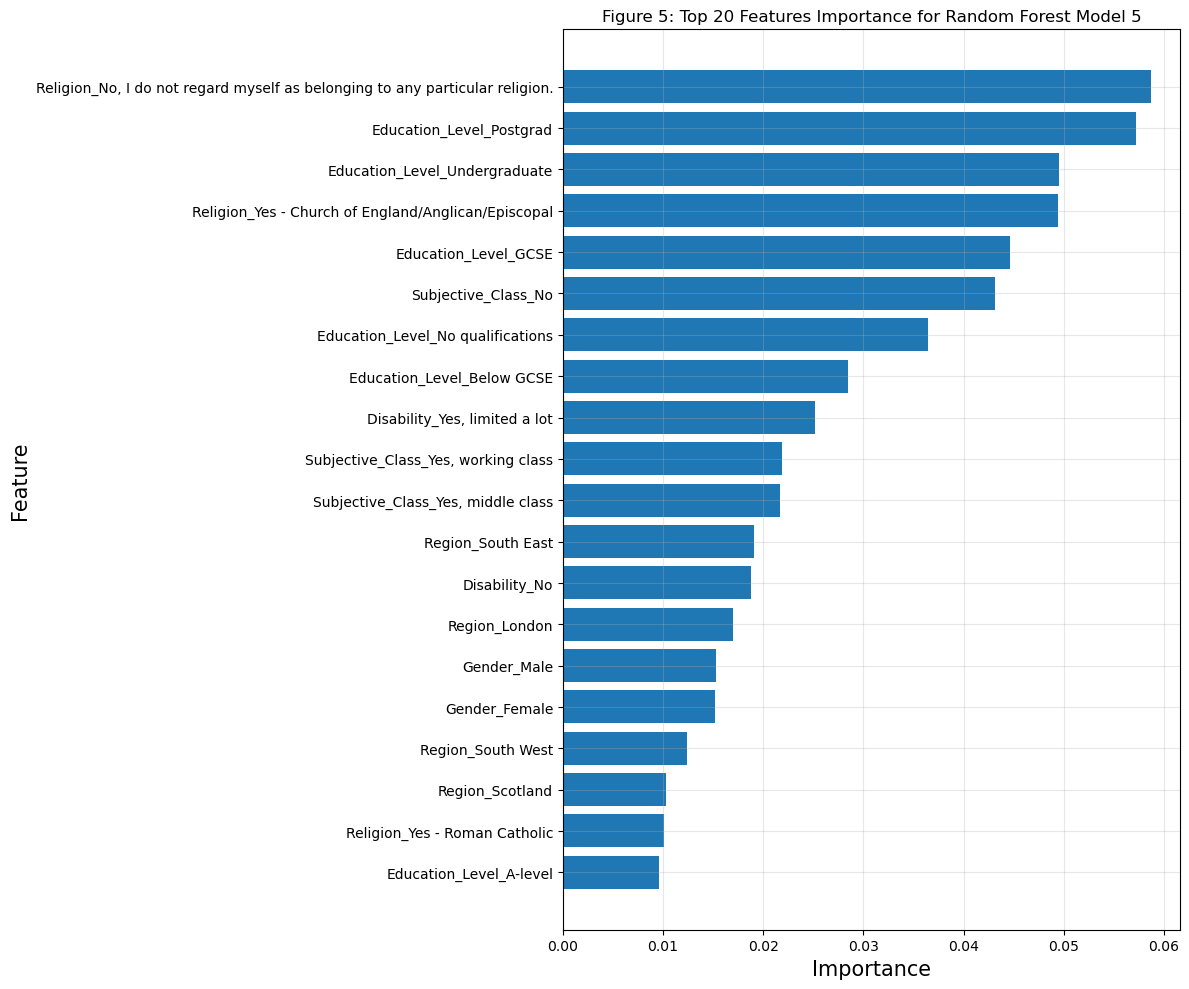

In [24]:
#Feature importance for model 5
importances = rf5.feature_importances_

sorted_idx = np.argsort(importances)[::-1]
top_idx = sorted_idx[:20]
sorted_features = [features[i] for i in top_idx]
sorted_importances = importances[top_idx]

plt.figure(figsize = (12, 10))
plt.barh(sorted_features, sorted_importances)
plt.xlabel('Importance', fontsize = 15)
plt.ylabel('Feature', fontsize = 15)
plt.title('Figure 5: Top 20 Features Importance for Random Forest Model 5')
plt.grid(alpha = 0.3)
plt.gca().invert_yaxis()

plt.tight_layout()
plt.savefig('Figure_5.png')

#### **Comparison**

In [25]:
#K-Fold Cross Validation for XGBoost
from sklearn.model_selection import cross_val_score

xgb_val = model5

xgb_precision = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'precision') 

xgb_recall = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'recall')

xgb_f1 = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'f1')

xgb_prauc = cross_val_score(xgb_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'average_precision')


In [26]:
#K-Fold Cross Validation for Random Forest
rf_val = rf5

rf_precision = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'precision') 

rf_recall = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'recall')

rf_f1 = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'f1')

rf_prauc = cross_val_score(rf_val, BES_train_stratified[features], BES_train_stratified[target], cv = 5, scoring = 'average_precision')

In [27]:
#Add all scores into one dataframe
cv_scores = pd.DataFrame({
    'Model': (['XGBoost'] * 20) + (['Random Forest'] * 20),
    'Metric': (['Precision'] * 5 + ['Recall'] * 5 + ['F1'] * 5 + ['PR-AUC'] * 5) * 2,
    'Score': list(xgb_precision) + list(xgb_recall) + list(xgb_f1) + list(xgb_prauc) +
             list(rf_precision) + list(rf_recall) + list(rf_f1) + list(rf_prauc)})

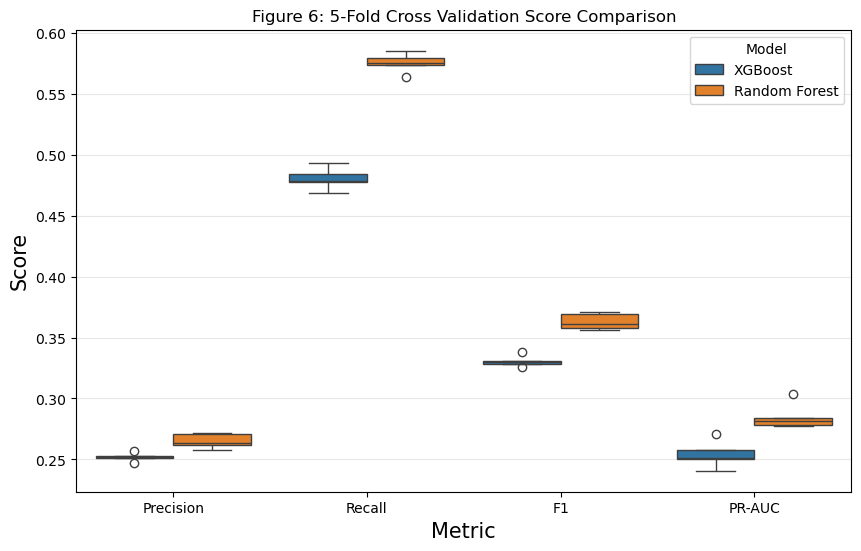

In [28]:
#Plot boxplot of CV scores by metric and score with models differentiated
import seaborn as sns

plt.figure(figsize = (10, 6))
sns.boxplot(data = cv_scores, x = 'Metric', y = 'Score', hue = 'Model')

plt.title('Figure 6: 5-Fold Cross Validation Score Comparison')
plt.ylabel('Score', fontsize = 15)
plt.xlabel('Metric', fontsize = 15)
plt.legend(title = 'Model')
plt.grid(axis = 'y', alpha = 0.3)

plt.savefig('Figure_6.png')

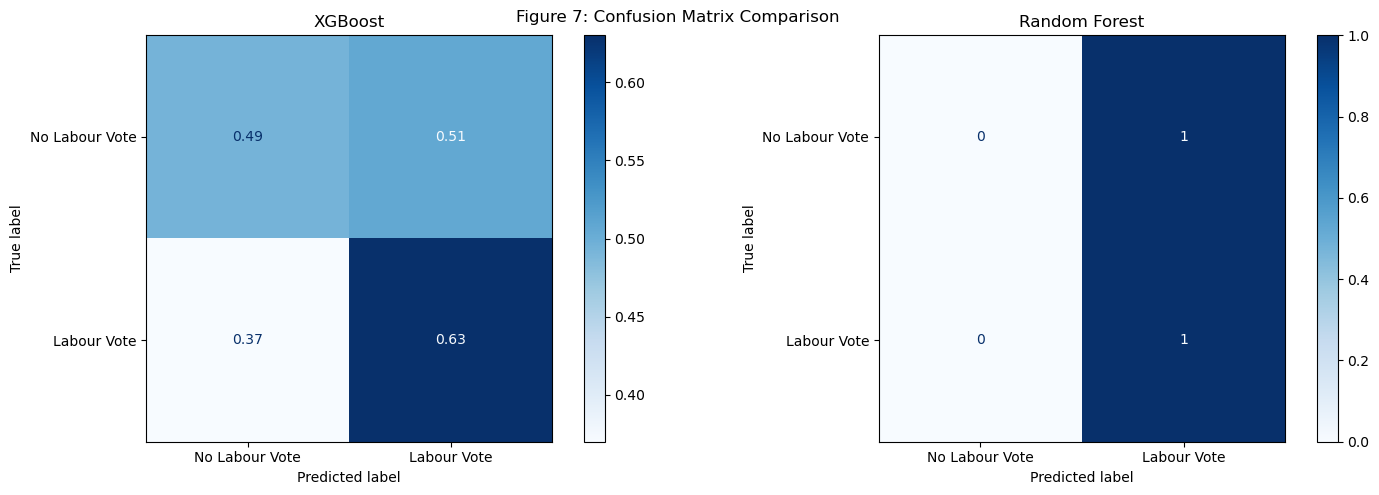

In [29]:
#Confusion Matrix
from sklearn.metrics import ConfusionMatrixDisplay

figures, axes = plt.subplots(1, 2, figsize = (15, 5))

ConfusionMatrixDisplay.from_predictions(BES_test_stratified[target], pred5, display_labels = ['No Labour Vote', 'Labour Vote'], 
                                        ax = axes[0], normalize = 'true', cmap = 'Blues')
axes[0].set_title('XGBoost')


ConfusionMatrixDisplay.from_predictions(BES_test_stratified[target], rf_pred5, display_labels = ['No Labour Vote', 'Labour Vote'], 
                                        ax = axes[1], normalize = 'true', cmap = 'Blues')
axes[1].set_title('Random Forest')

plt.tight_layout()
plt.suptitle('Figure 7: Confusion Matrix Comparison')
plt.savefig('Figure_7.png')

### **Appendices**

#### **Appendix A - Github Repository Link**

https://github.com/RyanWhitehead-04/MLSDS-Problem-Set-1.git

#### **Appendix B - Google Antigravity AI Agent Chat History**

# Chat Conversation

Note: _This is purely the output of the chat conversation and does not contain any raw data, codebase snippets, etc. used to generate the output._

### User Input

I have British Election study wave data loaded in a pandas dataframe called BES.
The target variable is 'Labour_vote' (0 or 1) and all the other columns are binary features (0/1). 
I have already split the data into training (80%) and testing (20%), and stratified this to overcome class imbalance, the training and test datasets are called BES_training_stratified and BES_testing_stratified, respectively.

Please help me:
1. Set up a hyperopt search space for XGBclassifier hyperparamters (max_depth, learning_rate, n_estimators, subsample, colsample_bytree, min_child_weight, and gamma).
2. Define a objective function that minimises negative F1 score.
3. Run Bayesian optimisation with 50 evaluations.
4. Add comments explaining each step.

Provide the code so I can copy and paste it into my notebook. 

### Planner Response

Here is the complete code to set up and run the Bayesian optimization for your XGBoost model using `hyperopt`. I have structured it sequentially so you can copy and paste it directly into your Jupyter Notebook.

```python
import numpy as np
from xgboost import XGBClassifier
from sklearn.metrics import f1_score
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
from hyperopt.pyll.base import scope

# --- PREPARATION ---

# First, separate your features (X) and target variable (y) from your datasets
X_train = BES_training_stratified.drop('Labour_vote', axis=1)
y_train = BES_training_stratified['Labour_vote']

X_test = BES_testing_stratified.drop('Labour_vote', axis=1)
y_test = BES_testing_stratified['Labour_vote']


# --- STEP 1: Set up the hyperopt search space ---

# Define the boundaries for the XGBClassifier hyperparameters you want to optimize
# - hp.quniform returns values rounded to the nearest given step (useful for integers)
# - hp.uniform returns continuous floats within the range
space = {
    'max_depth': hp.quniform('max_depth', 3, 10, 1),              # Depth of the tree (integers roughly 3 to 10)
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.3),      # Step size shrinkage (continuous 0.01 to 0.3)
    'n_estimators': hp.quniform('n_estimators', 50, 500, 10),     # Number of boosting rounds (trees)
    'subsample': hp.uniform('subsample', 0.5, 1.0),               # Fraction of observations to safely sample per tree
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0), # Fraction of columns to sample per tree
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),# Minimum instance weight needed in a child
    'gamma': hp.uniform('gamma', 0.0, 5.0)                        # Minimum loss reduction required for split
}


# --- STEP 2: Define objective function minimizing negative F1 score ---

def objective(params):
    # hyperopt passes parameters as floats by default if using uniform/quniform.
    # We must cast the hyperparameters that XGBoost expects to be integers.
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    
    # Initialize the XGBClassifier with the current set of parameters proposed by hyperopt
    clf = XGBClassifier(
        **params,
        random_state=42,       # Ensures reproducibility
        eval_metric='logloss'  # Prevents unnecessary iteration warnings in newer XGBoost versions
    )
    
    # Train the model on the stratified training data
    clf.fit(X_train, y_train)
    
    # Predict on the stratified test data
    preds = clf.predict(X_test)
    
    # Calculate the positive F1 score (harmonic mean of precision and recall)
    f1 = f1_score(y_test, preds)
    
    # hyperopt is designed to strictly MINIMIZE the return value of the objective function.
    # Therefore, to maximize the F1 score, we return the negative F1 score. 
    # STATUS_OK tells hyperopt that the function executed successfully without errors.
    return {'loss': -f1, 'status': STATUS_OK}


# --- STEP 3: Run Bayesian optimization with 50 evaluations ---

# The Trials object will keep a record of all the hyperparameters and corresponding losses evaluated
trials = Trials()

# fmin is the main optimization function built into hyperopt
best = fmin(
    fn=objective,                    # The objective function we just defined above
    space=space,                     # The hyperparameter search space
    algo=tpe.suggest,                # The optimization algorithm (Tree-structured Parzen Estimator)
    max_evals=50,                    # The number of models/evaluations to test (50, as requested)
    trials=trials,                   # The history dictionary to record metrics
    rstate=np.random.default_rng(42) # Random state for consistent/reproducible optimization behavior
)

# Output the best hyperparameters discovered
print("Best hyperparameters found during the Bayseian Search:")
print(best)
```

### A Brief Note on the Final Output
When you print the `best` dictionary at the end, remember that hyperopt returns exact float values for all `quniform` searches. If you decide to train a final, permanent model on these best parameters, remember to cast the integers where necessary, for example: `max_depth = int(best['max_depth'])`.